In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN # clustering algorithms
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.metrics import silhouette_score # used as a metric to evaluate the cohesion in a cluster
from sklearn.neighbors import NearestNeighbors # for selecting the optimal eps value when using DBSCAN

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

In [10]:
data = pd.read_csv('../dataset/all_data.csv')
data_pca_tranformed = pd.read_excel("../dataset/pca_transformed_data.xlsx",index_col="Unnamed: 0")
features = data.select_dtypes(include=[np.number]) 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [11]:
data.head()

,PLAYER,Year,advanced_OFFRTG,advanced_DEFRTG,advanced_NETRTG,advanced_AST%,advanced_AST/TO,advanced_AST Ratio,advanced_OREB%,advanced_DREB%,...,use_%DREB,use_%REB,use_%AST,use_%TOV,use_%STL,use_%BLK,use_%BLKA,use_%PF,use_%PFD,use_%PTS
0,_2000_Chris Gatling,2000,99.4,100.6,-1.3,6.8,0.42,5.9,8.0,18.4,...,30.1,29.5,9.0,25.6,26.7,10.6,26.8,25.0,4.2,27.2
1,_2000_Allen Iverson,2000,102.0,99.9,2.0,22.0,1.43,12.8,2.4,7.0,...,11.3,10.3,24.5,26.0,24.8,1.7,35.3,11.8,2.3,34.3
2,_2000_Shaquille O'Neal,2000,107.7,96.2,11.5,18.4,1.34,11.8,10.5,21.9,...,33.7,34.9,18.9,24.7,7.5,53.7,23.5,18.6,0.7,35.0
3,_2000_Karl Malone,2000,109.4,100.7,8.6,19.7,1.32,13.0,6.4,22.3,...,34.2,32.1,18.4,26.6,15.6,22.3,27.7,15.4,1.5,33.8
4,_2000_Tim Duncan,2000,103.6,95.0,8.6,15.2,0.97,11.5,9.8,21.7,...,32.9,34.5,17.2,26.8,15.1,39.2,32.5,17.1,1.4,29.7


In [12]:
column_names = list(data.columns)
print(column_names)

['PLAYER', 'Year', 'advanced_OFFRTG', 'advanced_DEFRTG', 'advanced_NETRTG', 'advanced_AST%', 'advanced_AST/TO', 'advanced_AST\xa0Ratio', 'advanced_OREB%', 'advanced_DREB%', 'advanced_REB%', 'advanced_TO\xa0Ratio', 'advanced_eFG%', 'advanced_TS%', 'advanced_USG%', 'advanced_PACE', 'advanced_PIE', 'advanced_POSS', 'defense_DEF\xa0RTG', 'defense_DREB', 'defense_DREB%', 'defense_%DREB', 'defense_STL', 'defense_STL%', 'defense_BLK', 'defense_%BLK', 'defense_OPP\xa0PTSOFF\xa0TOV', 'defense_OPP\xa0PTS2ND\xa0CHANCE', 'defense_OPP\xa0PTSFB', 'defense_OPP\xa0PTSPAINT', 'defense_DEFWS', 'per_game_MIN', 'per_game_PTS', 'per_game_FGM', 'per_game_FGA', 'per_game_FG%', 'per_game_3PM', 'per_game_3PA', 'per_game_3P%', 'per_game_FTM', 'per_game_FTA', 'per_game_FT%', 'per_game_OREB', 'per_game_DREB', 'per_game_REB', 'per_game_AST', 'per_game_TOV', 'per_game_STL', 'per_game_BLK', 'per_game_PF', 'per_game_FP', 'per_game_DD2', 'per_game_TD3', 'per_game_+/-', 'use_USG%', 'use_%FGM', 'use_%FGA', 'use_%3PM', '

In [13]:
scalered_data_by_year = {}

for i in range(2000, 2023):
    df = data[data["Year"] == i]

    numeric_columns = df.select_dtypes(include=[np.number])
    non_numeric_columns = df.select_dtypes(exclude=[np.number])

    df_array = numeric_columns.to_numpy()

    scaler = MinMaxScaler()
    scaler.fit(df_array)
    scaled_df_array = scaler.transform(df_array)

    scaled_df = pd.DataFrame(scaled_df_array, index=numeric_columns.index, columns=numeric_columns.columns)
    scaled_df = pd.concat([scaled_df, non_numeric_columns], axis=1)

    scalered_data_by_year[i] = scaled_df

arr = scalered_data_by_year[2000]
for i in range(2001, 2023):
    arr = pd.concat([arr, scalered_data_by_year[i]])

data_scaled = pd.DataFrame(data=arr, index=data.index, columns=data.columns)


In [6]:
def elbowPlot(range_, data, figsize=(10, 10)):
    """
    Generates an elbow plot to help determine the optimal number of clusters for KMeans clustering.
    The plot shows the inertia (within-cluster sum of squares) as a function of the number of clusters.
    
    Parameters:
        range_ (iterable): Range of cluster counts to test.
        data (array-like): Dataset for clustering.
        figsize (tuple): Size of the figure to be plotted.
    
    Returns:
        None. Displays and saves the plot as 'elbow_plot.png'.
    """
    inertia_list = []
    for n in range_:
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)

    # Plotting
    plt.figure(figsize=figsize)
    sns.lineplot(x=range_, y=inertia_list, marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.xticks(list(range_))
    plt.title("Elbow Plot for Determining Optimal Cluster Count")
    plt.savefig("elbow_plot.png")  # Save the figure
    plt.show()


In [14]:
def findOptimalEps(n_neighbors, data):
    '''
    function to find optimal eps distance when using DBSCAN; based on this article: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    '''
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.xlabel("Data Points")
    plt.ylabel("Distance")
    plt.savefig("eps_plot.png")

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

def progressiveFeatureSelection(df, n_clusters, max_features, verbose=True):
    '''
    A basic implementation of an algorithm for feature selection in unsupervised clustering scenarios.
    It progressively selects features that maximize the silhouette score of a KMeans clustering model.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the features.
        n_clusters (int): Number of clusters to use in KMeans.
        max_features (int): Maximum number of features to select.
        verbose (bool): If True, print progress messages.

    Returns:
        list: List of selected feature names.
    '''
    from sklearn.preprocessing import StandardScaler
    
    # Scale data
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    feature_list = list(scaled_df.columns)
    selected_features = []

    # Initial feature selection based on individual silhouette scores
    high_score = -1  # Initialize to -1 to ensure any real score is higher
    initial_feature = ""
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = scaled_df[[feature]]
        labels = kmeans.fit_predict(data_)
        score_ = silhouette_score(data_, labels)
        if verbose:
            print(f"Proposed new feature {feature} with score {score_}")
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    
    if verbose:
        print(f"The initial feature is {initial_feature} with a silhouette score of {high_score}.")

    selected_features.append(initial_feature)
    feature_list.remove(initial_feature)
    
    # Progressive selection of additional features
    for _ in range(max_features - 1):
        high_score = -1  # Reset high score for each new feature selection
        selected_feature = ""
        
        if verbose:
            print(f"Starting selection {_ + 1}...")
        
        for feature in feature_list:
            selection_ = selected_features + [feature]
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = scaled_df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            
            if verbose:
                print(f"Proposed new feature {feature} with score {score_}")
            
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        
        if verbose:
            print(f"Selected new feature {selected_feature} with score {high_score}")
    
    return selected_features


C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\clust

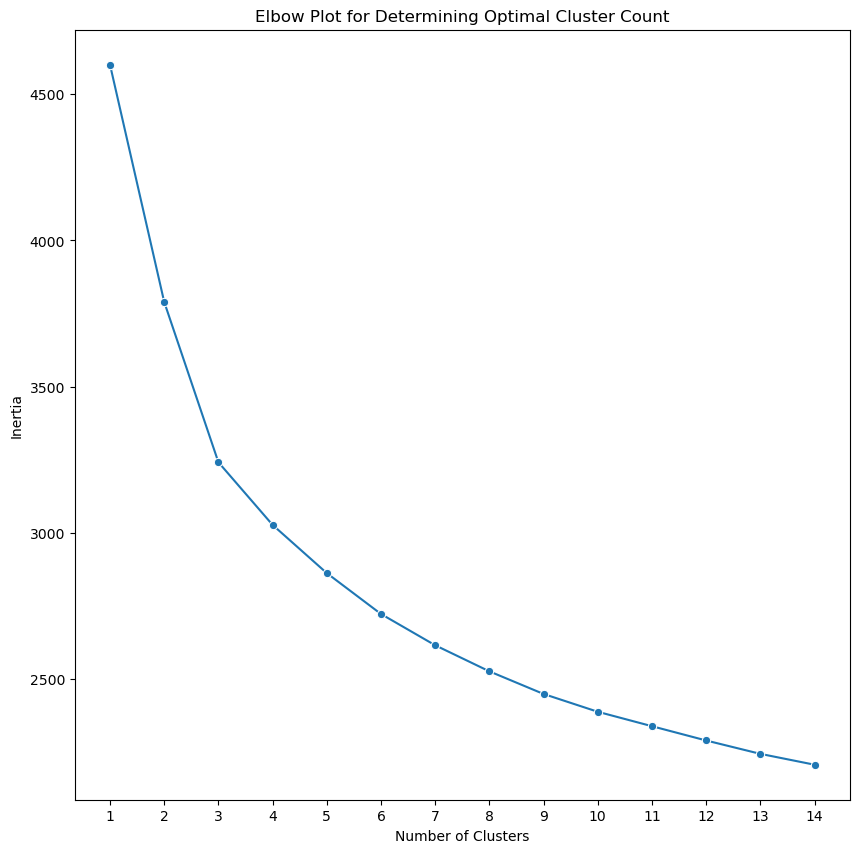

In [16]:
elbowPlot(range(1,15), data_pca_tranformed)

In [17]:
score_dict_pca = {}
for i in range(2,15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    data_ = data_pca_tranformed
    labels = kmeans.fit_predict(data_)
    score_ = silhouette_score(data_, labels)
    score_dict_pca[i] = score_
score_dict_pca

C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\clust

{2: 0.16118786362873744,
 3: 0.16655330207118682,
 4: 0.14307757661645384,
 5: 0.13273484143670475,
 6: 0.12491629368356548,
 7: 0.1191515888874122,
 8: 0.11363750245502383,
 9: 0.10871750829583153,
 10: 0.1068997966660376,
 11: 0.10516387375080943,
 12: 0.1023819986178204,
 13: 0.10082044735927514,
 14: 0.09983383232185383}

In [18]:
x_value = range(2,15)
y_value = [score_dict_pca[i] for i in x_value]

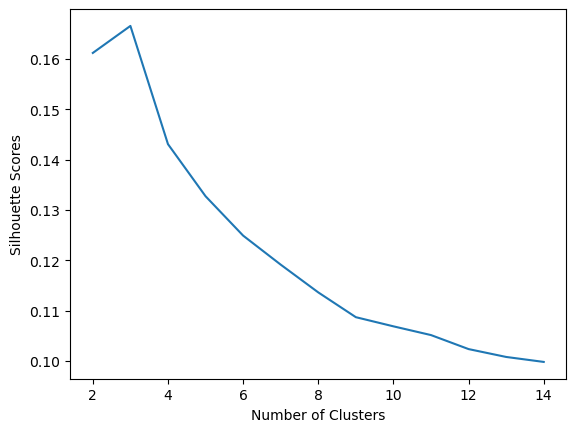

<Figure size 640x480 with 0 Axes>

In [19]:
x = x_value
y = y_value
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Scores")
plt.plot(x,y)
plt.show()
plt.savefig('silhouette_score_Kmeans_PCA.png')

In [20]:
kmeans = KMeans(n_clusters=10, random_state=0)
data_ = data_pca_tranformed
labels = kmeans.fit_predict(data_)
data_pca_tranformed["clusters"] = labels
cluster_array = data_pca_tranformed["clusters"].to_numpy()
cluster_df = pd.DataFrame(cluster_array,columns=["clusters"])

C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 0].index].describe()
pca_cluster_1 = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 0].index]
pca_cluster_1.to_excel('../results/pca_cluster_KM_cluster1.xlsx')


In [23]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 1].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 1].index]
pca_cluster.to_excel('../results/pca_cluster_KM_cluster2.xlsx')


In [24]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 2].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 2].index]
pca_cluster.to_excel('../results/pca_cluster_KM_cluster3.xlsx')



In [25]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 3].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 3].index]
pca_cluster.to_excel('../results/pca_cluster_KM_cluster4.xlsx')


In [26]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 4].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 4].index]
pca_cluster.to_excel('../results/pca_cluster_KM_cluster5.xlsx')


In [27]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 5].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 6].index]
pca_cluster.to_excel('../results/pca_cluster_KM_cluster6.xlsx')


In [28]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 6].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 6].index]
pca_cluster.to_excel('../results/pca_cluster_KM_cluster7.xlsx')


In [29]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 7].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 7].index]
pca_cluster.to_excel('../results/pca_cluster_KM_cluster8.xlsx')


In [30]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 8].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 8].index]
pca_cluster.to_excel('../results/pca_cluster_KM_cluster9.xlsx')


In [31]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 9].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 9].index]
pca_cluster.to_excel('../results/pca_cluster_KM_cluster10.xlsx')

In [32]:
data_pca_tranformed.drop(columns="clusters")
score_dict_ward = {}
for i in range(2,15):
    clusterer = AgglomerativeClustering(n_clusters=i, linkage='ward')
    data_ = data_pca_tranformed
    y_predict = clusterer.fit_predict(data_)
    cluster_labels = clusterer.labels_
    score_ = silhouette_score(data_, cluster_labels)
    score_dict_ward[i] = score_
score_dict_ward

{2: 0.5802650284171125,
 3: 0.5110817809068259,
 4: 0.43452773523802785,
 5: 0.4361956148268254,
 6: 0.45802327840097995,
 7: 0.449204656081102,
 8: 0.4727021566523524,
 9: 0.48767785001188574,
 10: 0.518078602257642,
 11: 0.46341457211422277,
 12: 0.42075555333806836,
 13: 0.3860776791548733,
 14: 0.3565164322428456}

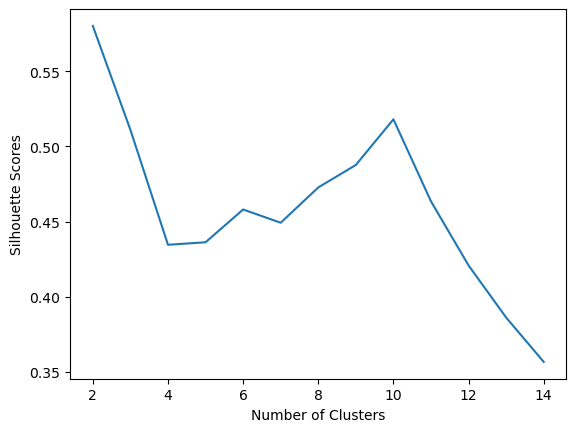

<Figure size 640x480 with 0 Axes>

In [33]:
x_value = range(2,15)
y_value = [score_dict_ward[i] for i in x_value]
x = x_value
y = y_value
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Scores")
plt.plot(x,y)
plt.show()
plt.savefig('silhouette_score_Hierarchical_PCA.png')

In [34]:
##Choose n_cluster = 10
clusterer = AgglomerativeClustering(n_clusters=10, linkage='ward')
data_ = data_pca_tranformed
y_predict = clusterer.fit_predict(data_)
cluster_labels = clusterer.labels_

In [35]:
pca = PCA(n_components=2, whiten=False, random_state=42)
data_pca_tranformed_2dpca = pca.fit_transform(data_pca_tranformed)
df_data_pca_tranformed_2dpca = pd.DataFrame(data=data_pca_tranformed_2dpca, columns=["PCA_1", "PCA_2"])
df_data_pca_tranformed_2dpca["clusters"] = cluster_labels

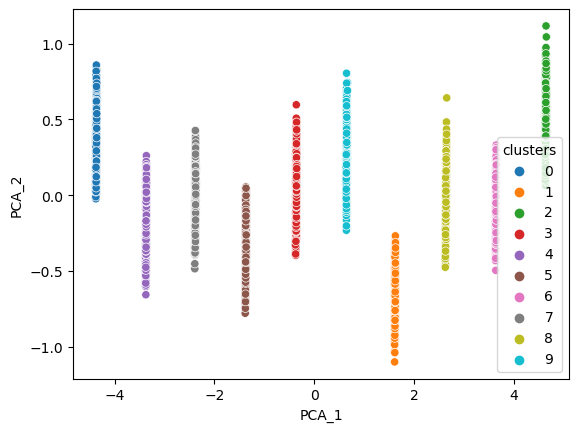

In [39]:
sns_plot = sns.scatterplot(x="PCA_1", y="PCA_2", hue="clusters", palette="tab10", data=df_data_pca_tranformed_2dpca)

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

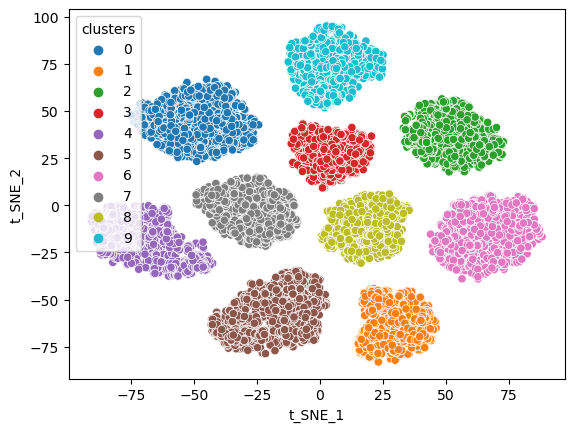

In [43]:
tsne = TSNE(n_components=2, perplexity=20)
data_2d = tsne.fit_transform(data_pca_tranformed)
df_data_2d = pd.DataFrame(data=data_2d, columns=["t_SNE_1", "t_SNE_2"])
df_data_2d["clusters"] = cluster_labels
sns_plot = sns.scatterplot(x="t_SNE_1", y="t_SNE_2", hue="clusters", palette="tab10", data=df_data_2d)

C:\Users\anshm\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0, 0.5, 'UMAP_2')

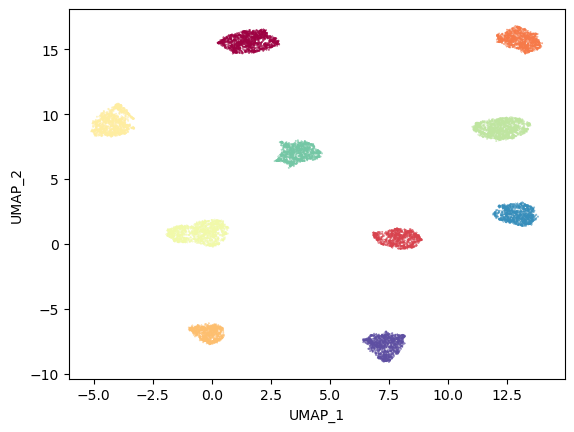

In [49]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(data_pca_tranformed)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c= cluster_labels, s=0.1, cmap='Spectral')
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")

In [50]:
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 0].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 0].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster1.xlsx')
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 1].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 1].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster2.xlsx')
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 2].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 2].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster3.xlsx')
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 3].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 3].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster4.xlsx')
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 4].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 4].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster5.xlsx')
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 5].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 5].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster6.xlsx')
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 6].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 6].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster7.xlsx')
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 7].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 7].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster8.xlsx')
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 8].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 8].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster9.xlsx')
data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 9].index].describe()
pca_cluster = data_pca_tranformed.iloc[cluster_df[cluster_df["clusters"] == 9].index]
pca_cluster.to_excel('../results/pca_cluster_Hie_cluster10.xlsx')

In [52]:
## Use the manual selected features to do the clustering again
all_data = pd.read_excel('../dataset/all_data_manual_selected.xlsx',index_col = "PLAYER")
all_data

,YEAR,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-
PLAYER,,,,,,,,,,,
_2000_Shaquille O'Neal,2000,3165,107.7,96.2,10.5,8.8,94.28,40.1,12.1,21.1,8.9
_2000_Allen Iverson,2000,2856,102.0,99.9,2.4,9.0,95.34,40.8,10.4,24.8,1.8
_2000_Tim Duncan,2000,2879,103.6,95.0,9.8,11.9,92.89,38.9,8.5,17.3,6.4
_2000_Karl Malone,2000,2946,109.4,100.7,6.4,9.9,92.30,35.9,9.2,18.0,5.9
_2000_Chris Gatling,2000,1810,99.4,100.6,8.0,14.0,99.53,21.3,4.3,9.4,-0.7
...,...,...,...,...,...,...,...,...,...,...,...
_2022_Royce O'Neale,2022,2406,115.8,110.5,2.7,10.7,98.50,31.2,2.6,5.8,3.0
_2022_John Konchar,2022,1292,109.7,107.0,5.9,6.9,101.72,17.9,1.9,3.6,1.3
_2022_Matisse Thybulle,2022,1685,110.9,107.2,2.6,9.0,97.32,25.5,2.3,4.5,1.3


In [53]:
column_names = list(all_data.columns)
scalered_data_by_year = {}
for i in range(2000,2023):
    # select the data from that year
    df = all_data[all_data["YEAR"] == i]
    df_array = df.to_numpy()
    scaler = MinMaxScaler()
    scaler.fit(df_array)
    scalered_df = scaler.transform(df_array)
    scalered_data_by_year[i] = scalered_df
#merge all the arrays to one
arr = scalered_data_by_year[2000]
for i in range(2001,2023):
    arr = np.vstack((arr,scalered_data_by_year[i]))
index_values = list(all_data.index)
all_data_scaled = pd.DataFrame(data = arr,
                                 index = index_values,
                                 columns = column_names)

all_data_scaled = all_data_scaled.drop(columns = ['YEAR'])
all_data_scaled

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-
_2000_Shaquille O'Neal,0.904367,0.833333,0.264574,0.684564,0.183036,0.299479,0.938547,1.000000,0.843882,1.000000
_2000_Allen Iverson,0.805865,0.601626,0.430493,0.140940,0.191964,0.368490,0.958101,0.855932,1.000000,0.614130
_2000_Tim Duncan,0.813197,0.666667,0.210762,0.637584,0.321429,0.208984,0.905028,0.694915,0.683544,0.864130
_2000_Karl Malone,0.834555,0.902439,0.466368,0.409396,0.232143,0.170573,0.821229,0.754237,0.713080,0.836957
_2000_Chris Gatling,0.472426,0.495935,0.461883,0.516779,0.415179,0.641276,0.413408,0.338983,0.350211,0.478261
...,...,...,...,...,...,...,...,...,...,...
_2022_Royce O'Neale,0.822293,0.860082,0.483871,0.119171,0.500000,0.345900,0.781046,0.177570,0.219512,0.711443
_2022_John Konchar,0.380405,0.609053,0.358423,0.284974,0.250000,0.649387,0.346405,0.112150,0.112195,0.626866
_2022_Matisse Thybulle,0.536295,0.658436,0.365591,0.113990,0.388158,0.234684,0.594771,0.149533,0.156098,0.626866
_2022_Nerlens Noel,0.090837,0.378601,0.458781,0.414508,0.927632,0.384543,0.496732,0.056075,0.053659,0.427861


C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\clust

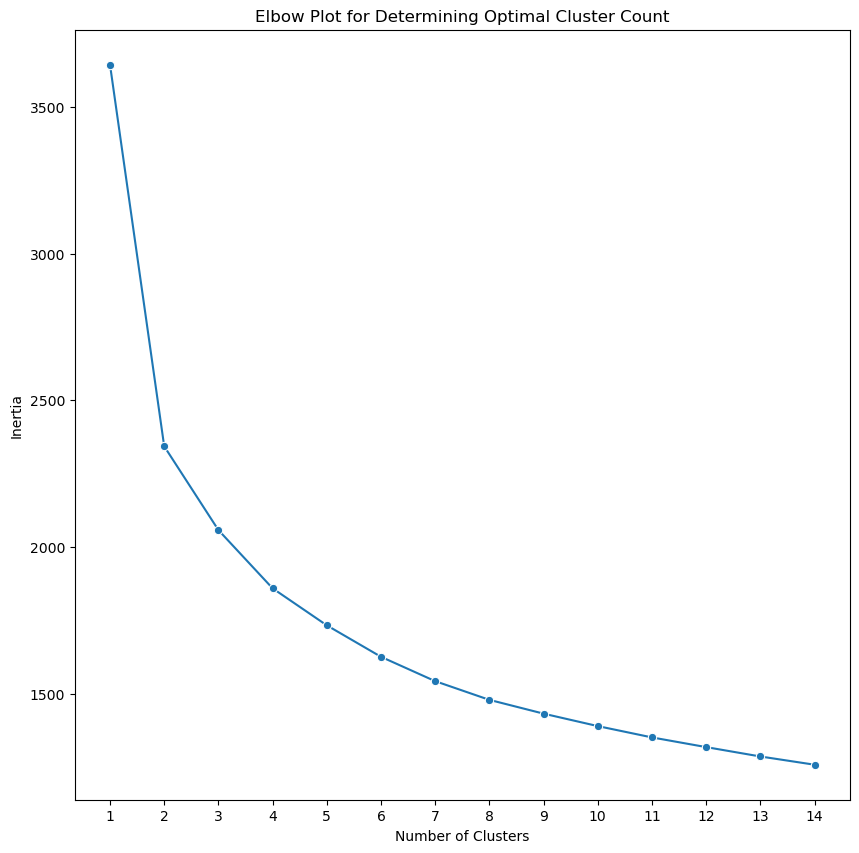

In [54]:

elbowPlot(range(1,15), all_data_scaled)

In [55]:
score_dict_pca = {}
for i in range(2,15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    data_ = all_data_scaled
    labels = kmeans.fit_predict(data_)
    score_ = silhouette_score(data_, labels)
    score_dict_pca[i] = score_
score_dict_pca

C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\clust

{2: 0.2984000424405067,
 3: 0.18614218853355993,
 4: 0.1719471474156312,
 5: 0.1649506846357439,
 6: 0.15795443572298704,
 7: 0.14763562652888185,
 8: 0.1405233992859616,
 9: 0.13266512714757492,
 10: 0.13244249112994552,
 11: 0.12902572447096586,
 12: 0.12445378652758135,
 13: 0.1258334023474577,
 14: 0.12786398546080546}

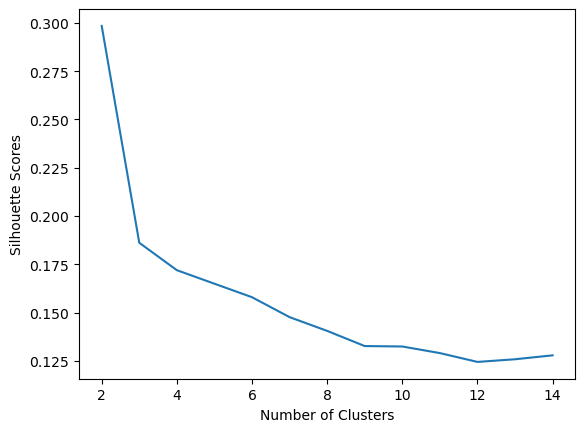

<Figure size 640x480 with 0 Axes>

In [56]:
x_value = range(2,15)
y_value = [score_dict_pca[i] for i in x_value]
x = x_value
y = y_value
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Scores")
plt.plot(x,y)
plt.show()
plt.savefig('silhouette_score_Kmenas_Manual.png')

In [57]:
## n_cluster = 10
kmeans = KMeans(n_clusters=10, random_state=0)
data_ = all_data_scaled
labels = kmeans.fit_predict(data_)
all_data_scaled["clusters"] = labels
cluster_array = all_data_scaled["clusters"].to_numpy()
cluster_df = pd.DataFrame(cluster_array,columns=["clusters"])

C:\Users\anshm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [58]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 0].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster1.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 0].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.0
mean,0.334021,0.535604,0.399026,0.168347,0.353362,0.326090,0.398991,0.201762,0.219664,0.493887,0.0
std,0.123978,0.131183,0.129542,0.116855,0.138678,0.121170,0.106361,0.073679,0.078702,0.107721,0.0
min,0.000741,0.168889,0.000000,0.000000,0.000000,0.000000,0.069930,0.010101,0.043689,0.215909,0.0
25%,0.259671,0.441493,0.318008,0.080537,0.260543,0.242404,0.326524,0.150943,0.162756,0.418719,0.0
50%,0.338913,0.528532,0.403968,0.136364,0.344660,0.323330,0.394817,0.195977,0.212676,0.486108,0.0
75%,0.423812,0.623377,0.486911,0.225959,0.436272,0.423126,0.468365,0.245283,0.268657,0.556981,0.0
max,0.647984,1.000000,0.727749,0.560606,1.000000,0.654971,0.767606,0.484211,0.537037,0.911392,0.0


In [59]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 1].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster2.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 1].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.0
mean,0.800678,0.753021,0.478656,0.263028,0.321892,0.414441,0.869645,0.719240,0.704789,0.698023,1.0
std,0.133525,0.117633,0.133115,0.181073,0.116846,0.191429,0.071496,0.130143,0.131950,0.138389,0.0
min,0.133156,0.411290,0.000000,0.027027,0.025157,0.026178,0.612536,0.457944,0.410714,0.395833,1.0
25%,0.737951,0.667870,0.395194,0.118609,0.237951,0.272360,0.823718,0.612245,0.601954,0.588753,1.0
50%,0.822011,0.752049,0.487023,0.201985,0.314021,0.405170,0.874038,0.702270,0.694384,0.690217,1.0
75%,0.891752,0.838681,0.574809,0.393134,0.401786,0.557493,0.917492,0.809915,0.796350,0.793824,1.0
max,1.000000,1.000000,0.854331,0.916667,0.690789,0.988146,1.000000,1.000000,1.000000,1.000000,1.0


In [60]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 2].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster3.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 2].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.0
mean,0.660770,0.681222,0.456642,0.164913,0.321485,0.396268,0.703495,0.388734,0.405371,0.611312,2.0
std,0.124818,0.118443,0.129962,0.111682,0.115515,0.172316,0.097208,0.096163,0.095896,0.122808,0.0
min,0.119523,0.315789,0.000000,0.000000,0.023669,0.000000,0.474860,0.135593,0.148855,0.318182,2.0
25%,0.590486,0.595331,0.363985,0.080537,0.244565,0.271379,0.631124,0.319588,0.337963,0.524590,2.0
50%,0.662588,0.680000,0.461207,0.135484,0.318182,0.385965,0.705128,0.386792,0.404580,0.597701,2.0
75%,0.747868,0.760714,0.551971,0.228188,0.392857,0.515682,0.775216,0.459184,0.475728,0.696203,2.0
max,0.980747,1.000000,0.866142,0.605882,0.787879,0.995766,1.000000,0.626263,0.673171,1.000000,2.0


In [61]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 3].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster4.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 3].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.0
mean,0.182712,0.454710,0.480275,0.628752,0.549963,0.448687,0.233346,0.131898,0.115155,0.409073,3.0
std,0.118925,0.162142,0.176028,0.138728,0.185762,0.189048,0.112989,0.068533,0.062333,0.107819,0.0
min,0.000000,0.028571,0.000000,0.288591,0.000000,0.000000,0.000000,0.000000,0.000000,0.054795,3.0
25%,0.082491,0.353571,0.364669,0.527664,0.417854,0.320663,0.150683,0.081220,0.068702,0.344545,3.0
50%,0.171448,0.451713,0.484979,0.618421,0.540179,0.445759,0.233429,0.127451,0.110687,0.409091,3.0
75%,0.275956,0.551065,0.591812,0.716932,0.657895,0.565696,0.308240,0.176777,0.154229,0.472866,3.0
max,0.538093,1.000000,1.000000,1.000000,1.000000,1.000000,0.720670,0.401869,0.384279,0.750000,3.0


In [62]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 4].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster5.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 4].index].describe()


,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.0
mean,0.102204,0.373975,0.350853,0.204826,0.380502,0.553095,0.159521,0.096914,0.114063,0.433656,4.0
std,0.078894,0.159138,0.145601,0.138963,0.162381,0.182822,0.089303,0.051917,0.056240,0.084675,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.043439,0.000000,0.000000,0.000000,0.208333,4.0
25%,0.037037,0.267504,0.255628,0.091069,0.267903,0.413788,0.089636,0.059322,0.072841,0.374271,4.0
50%,0.084249,0.384948,0.374000,0.170935,0.383571,0.551994,0.153846,0.091837,0.107317,0.433854,4.0
75%,0.153810,0.481481,0.456536,0.291082,0.484175,0.684665,0.220200,0.127451,0.149038,0.486486,4.0
max,0.359468,0.974026,0.677165,0.605263,0.973684,1.000000,0.505155,0.326087,0.369792,0.746269,4.0


In [63]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 5].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster6.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 5].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.0
mean,0.537374,0.604576,0.496759,0.648508,0.440117,0.357153,0.581528,0.346642,0.299347,0.493322,5.0
std,0.152785,0.136252,0.159364,0.134178,0.139709,0.165175,0.130114,0.117245,0.106284,0.152507,0.0
min,0.005864,0.277259,0.028302,0.336066,0.088757,0.000000,0.246914,0.058824,0.041494,0.011364,5.0
25%,0.443085,0.505837,0.391304,0.544828,0.343220,0.237934,0.477663,0.262712,0.223301,0.381579,5.0
50%,0.531831,0.592982,0.500000,0.637584,0.432900,0.345830,0.574257,0.336842,0.292576,0.487342,5.0
75%,0.644008,0.696970,0.606936,0.738255,0.519737,0.468354,0.672269,0.420561,0.369295,0.595092,5.0
max,0.941547,1.000000,0.944882,1.000000,1.000000,0.926364,0.939103,0.798077,0.743119,0.980296,5.0


In [64]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 6].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster7.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 6].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.0
mean,0.519412,0.456469,0.657333,0.185277,0.364689,0.436364,0.610800,0.349001,0.376808,0.268843,6.0
std,0.143992,0.126761,0.129365,0.134452,0.128126,0.155077,0.099420,0.091065,0.096857,0.109914,0.0
min,0.002692,0.008097,0.324607,0.000000,0.053691,0.035242,0.362776,0.066038,0.075472,0.000000,6.0
25%,0.437066,0.378155,0.572939,0.083009,0.274937,0.328797,0.536252,0.284236,0.307292,0.196556,6.0
50%,0.531046,0.455241,0.649688,0.142910,0.358333,0.428115,0.607908,0.345974,0.374227,0.280805,6.0
75%,0.620419,0.542181,0.743478,0.259939,0.446429,0.544302,0.681818,0.413710,0.442374,0.352479,6.0
max,0.844074,0.878788,1.000000,0.688742,0.913978,0.873811,0.904930,0.704082,0.677725,0.544304,6.0


In [65]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 7].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster8.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 7].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.0
mean,0.362100,0.588669,0.520835,0.226352,0.335492,0.669371,0.436394,0.256234,0.268486,0.468137,7.0
std,0.132018,0.136496,0.132037,0.147377,0.138492,0.128625,0.114561,0.088801,0.088835,0.113068,0.0
min,0.000000,0.194332,0.039474,0.000000,0.000000,0.365890,0.106796,0.065421,0.083333,0.156250,7.0
25%,0.273510,0.493634,0.436507,0.106061,0.233736,0.571781,0.359351,0.189275,0.200000,0.387457,7.0
50%,0.375144,0.584181,0.522917,0.191881,0.330357,0.655845,0.433278,0.248810,0.260164,0.457746,7.0
75%,0.456705,0.680951,0.604606,0.335570,0.425770,0.753875,0.507083,0.305478,0.323876,0.535968,7.0
max,0.662514,1.000000,0.937008,0.684564,0.796053,1.000000,0.814189,0.547368,0.558252,0.939394,7.0


In [66]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 8].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster9.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 8].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.0
mean,0.737237,0.563100,0.662422,0.225208,0.336867,0.447698,0.833530,0.609760,0.626776,0.327023,8.0
std,0.151384,0.117259,0.125855,0.163971,0.109900,0.177869,0.075445,0.115979,0.113963,0.123839,0.0
min,0.148048,0.000000,0.317073,0.015152,0.048387,0.017280,0.595016,0.294118,0.349515,0.000000,8.0
25%,0.654819,0.485891,0.573249,0.100650,0.261276,0.328283,0.786728,0.525338,0.546875,0.250000,8.0
50%,0.766032,0.564516,0.661088,0.166667,0.331915,0.435240,0.836420,0.598039,0.614504,0.345070,8.0
75%,0.847870,0.642480,0.748031,0.318350,0.409243,0.568552,0.888600,0.683673,0.697582,0.421922,8.0
max,1.000000,0.982684,1.000000,0.870504,0.703947,0.995561,1.000000,1.000000,1.000000,0.601266,8.0


In [67]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 9].index]
selected_cluster.to_excel('../results/selected_cluster_KMeans_cluster10.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 9].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.0
mean,0.171699,0.355214,0.666540,0.201353,0.403079,0.466084,0.277675,0.155753,0.177166,0.284063,9.0
std,0.108794,0.140740,0.129844,0.142985,0.151673,0.168263,0.115523,0.070133,0.072984,0.092581,0.0
min,0.000000,0.000000,0.287554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.0
25%,0.082619,0.263158,0.573913,0.089655,0.295455,0.355218,0.192429,0.104167,0.125000,0.228723,9.0
50%,0.166237,0.362229,0.659751,0.157233,0.402367,0.454413,0.279661,0.149425,0.168142,0.292553,9.0
75%,0.245376,0.448560,0.744000,0.298013,0.500000,0.566318,0.357860,0.200000,0.221739,0.347826,9.0
max,0.507449,0.777328,1.000000,0.622951,0.975758,1.000000,0.600000,0.378947,0.514286,0.497041,9.0


In [68]:
score_dict_ward = {}
for i in range(2,15):
    clusterer = AgglomerativeClustering(n_clusters=i, linkage='ward')
    data_ = all_data_scaled
    y_predict = clusterer.fit_predict(data_)
    cluster_labels = clusterer.labels_
    score_ = silhouette_score(data_, cluster_labels)
    score_dict_ward[i] = score_
score_dict_ward

{2: 0.5839195487105413,
 3: 0.48532756216774325,
 4: 0.5093100288752433,
 5: 0.5223760893982002,
 6: 0.5084577286337716,
 7: 0.5194013074616554,
 8: 0.5243866192545451,
 9: 0.5472839743306315,
 10: 0.5814227571048772,
 11: 0.5410310042233976,
 12: 0.48707803761249885,
 13: 0.4387951580914434,
 14: 0.40644702306959013}

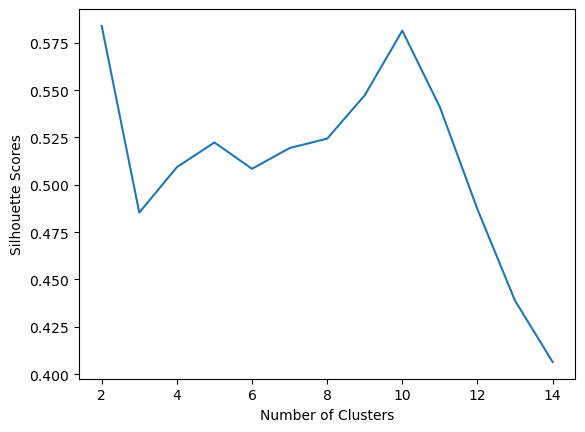

<Figure size 640x480 with 0 Axes>

In [69]:
x_value = range(2,15)
y_value = [score_dict_ward[i] for i in x_value]
x = x_value
y = y_value
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Scores")
plt.plot(x,y)
plt.show()
plt.savefig('silhouette_score_Hierarchical_Manual.png')

In [70]:
clusterer = AgglomerativeClustering(n_clusters=10, linkage='ward')
data_ = all_data_scaled
y_predict = clusterer.fit_predict(data_)
cluster_labels = clusterer.labels_

In [71]:
pca = PCA(n_components=2, whiten=False, random_state=42)
all_data_scaled_2d_pca = pca.fit_transform(all_data_scaled)
df_all_data_scaled_2d_pca = pd.DataFrame(data=all_data_scaled_2d_pca, columns=["PCA_1", "PCA_2"])
df_all_data_scaled_2d_pca["clusters"] = cluster_labels

In [72]:
df_all_data_scaled_2d_pca

,PCA_1,PCA_2,clusters
0,-3.384452,1.039141,7
1,-3.358878,0.979341,7
2,-3.377834,0.719670,7
3,-3.373863,0.829437,7
4,2.651141,-0.000919,5
...,...,...,...
8506,-2.363709,0.340405,8
8507,2.643933,-0.208439,5
8508,-4.356282,-0.019659,9
8509,-1.339305,-0.514912,1


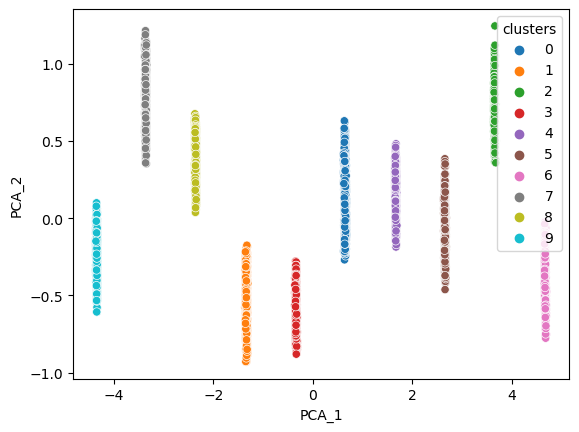

In [73]:
sns_plot = sns.scatterplot(x="PCA_1", y="PCA_2", hue="clusters", palette="tab10", data=df_all_data_scaled_2d_pca)

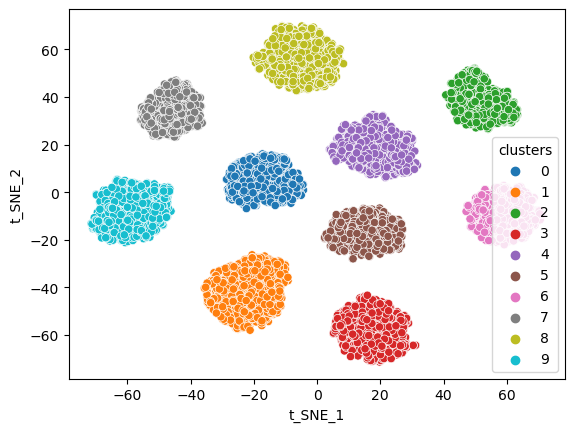

In [74]:
tsne = TSNE(n_components=2, perplexity=40)
data_2d = tsne.fit_transform(all_data_scaled)
df_data_2d = pd.DataFrame(data=data_2d, columns=["t_SNE_1", "t_SNE_2"])
df_data_2d["clusters"] = cluster_labels
sns_plot = sns.scatterplot(x="t_SNE_1", y="t_SNE_2", hue="clusters", palette="tab10", data=df_data_2d)

C:\Users\anshm\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0, 0.5, 'UMAP_2')

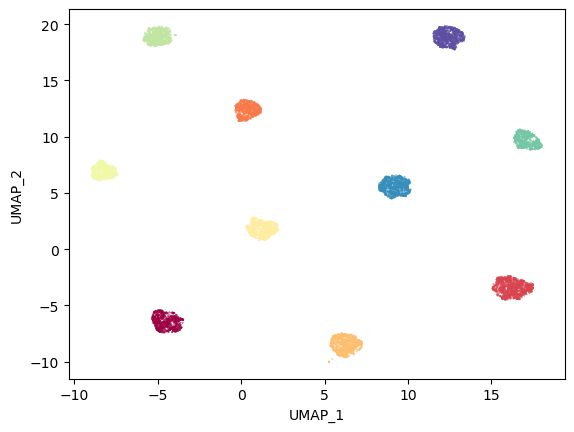

In [75]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(all_data_scaled)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c= cluster_labels, s=0.1, cmap='Spectral')
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")

In [76]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 0].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster1.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 0].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.0
mean,0.334021,0.535604,0.399026,0.168347,0.353362,0.326090,0.398991,0.201762,0.219664,0.493887,0.0
std,0.123978,0.131183,0.129542,0.116855,0.138678,0.121170,0.106361,0.073679,0.078702,0.107721,0.0
min,0.000741,0.168889,0.000000,0.000000,0.000000,0.000000,0.069930,0.010101,0.043689,0.215909,0.0
25%,0.259671,0.441493,0.318008,0.080537,0.260543,0.242404,0.326524,0.150943,0.162756,0.418719,0.0
50%,0.338913,0.528532,0.403968,0.136364,0.344660,0.323330,0.394817,0.195977,0.212676,0.486108,0.0
75%,0.423812,0.623377,0.486911,0.225959,0.436272,0.423126,0.468365,0.245283,0.268657,0.556981,0.0
max,0.647984,1.000000,0.727749,0.560606,1.000000,0.654971,0.767606,0.484211,0.537037,0.911392,0.0


In [77]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 1].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster2.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 1].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.0
mean,0.800678,0.753021,0.478656,0.263028,0.321892,0.414441,0.869645,0.719240,0.704789,0.698023,1.0
std,0.133525,0.117633,0.133115,0.181073,0.116846,0.191429,0.071496,0.130143,0.131950,0.138389,0.0
min,0.133156,0.411290,0.000000,0.027027,0.025157,0.026178,0.612536,0.457944,0.410714,0.395833,1.0
25%,0.737951,0.667870,0.395194,0.118609,0.237951,0.272360,0.823718,0.612245,0.601954,0.588753,1.0
50%,0.822011,0.752049,0.487023,0.201985,0.314021,0.405170,0.874038,0.702270,0.694384,0.690217,1.0
75%,0.891752,0.838681,0.574809,0.393134,0.401786,0.557493,0.917492,0.809915,0.796350,0.793824,1.0
max,1.000000,1.000000,0.854331,0.916667,0.690789,0.988146,1.000000,1.000000,1.000000,1.000000,1.0


In [78]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 2].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster3.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 2].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.0
mean,0.660770,0.681222,0.456642,0.164913,0.321485,0.396268,0.703495,0.388734,0.405371,0.611312,2.0
std,0.124818,0.118443,0.129962,0.111682,0.115515,0.172316,0.097208,0.096163,0.095896,0.122808,0.0
min,0.119523,0.315789,0.000000,0.000000,0.023669,0.000000,0.474860,0.135593,0.148855,0.318182,2.0
25%,0.590486,0.595331,0.363985,0.080537,0.244565,0.271379,0.631124,0.319588,0.337963,0.524590,2.0
50%,0.662588,0.680000,0.461207,0.135484,0.318182,0.385965,0.705128,0.386792,0.404580,0.597701,2.0
75%,0.747868,0.760714,0.551971,0.228188,0.392857,0.515682,0.775216,0.459184,0.475728,0.696203,2.0
max,0.980747,1.000000,0.866142,0.605882,0.787879,0.995766,1.000000,0.626263,0.673171,1.000000,2.0


In [79]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 3].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster4.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 3].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.0
mean,0.182712,0.454710,0.480275,0.628752,0.549963,0.448687,0.233346,0.131898,0.115155,0.409073,3.0
std,0.118925,0.162142,0.176028,0.138728,0.185762,0.189048,0.112989,0.068533,0.062333,0.107819,0.0
min,0.000000,0.028571,0.000000,0.288591,0.000000,0.000000,0.000000,0.000000,0.000000,0.054795,3.0
25%,0.082491,0.353571,0.364669,0.527664,0.417854,0.320663,0.150683,0.081220,0.068702,0.344545,3.0
50%,0.171448,0.451713,0.484979,0.618421,0.540179,0.445759,0.233429,0.127451,0.110687,0.409091,3.0
75%,0.275956,0.551065,0.591812,0.716932,0.657895,0.565696,0.308240,0.176777,0.154229,0.472866,3.0
max,0.538093,1.000000,1.000000,1.000000,1.000000,1.000000,0.720670,0.401869,0.384279,0.750000,3.0


In [80]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 4].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster5.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 4].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.0
mean,0.102204,0.373975,0.350853,0.204826,0.380502,0.553095,0.159521,0.096914,0.114063,0.433656,4.0
std,0.078894,0.159138,0.145601,0.138963,0.162381,0.182822,0.089303,0.051917,0.056240,0.084675,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.043439,0.000000,0.000000,0.000000,0.208333,4.0
25%,0.037037,0.267504,0.255628,0.091069,0.267903,0.413788,0.089636,0.059322,0.072841,0.374271,4.0
50%,0.084249,0.384948,0.374000,0.170935,0.383571,0.551994,0.153846,0.091837,0.107317,0.433854,4.0
75%,0.153810,0.481481,0.456536,0.291082,0.484175,0.684665,0.220200,0.127451,0.149038,0.486486,4.0
max,0.359468,0.974026,0.677165,0.605263,0.973684,1.000000,0.505155,0.326087,0.369792,0.746269,4.0


In [81]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 5].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster6.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 5].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.0
mean,0.537374,0.604576,0.496759,0.648508,0.440117,0.357153,0.581528,0.346642,0.299347,0.493322,5.0
std,0.152785,0.136252,0.159364,0.134178,0.139709,0.165175,0.130114,0.117245,0.106284,0.152507,0.0
min,0.005864,0.277259,0.028302,0.336066,0.088757,0.000000,0.246914,0.058824,0.041494,0.011364,5.0
25%,0.443085,0.505837,0.391304,0.544828,0.343220,0.237934,0.477663,0.262712,0.223301,0.381579,5.0
50%,0.531831,0.592982,0.500000,0.637584,0.432900,0.345830,0.574257,0.336842,0.292576,0.487342,5.0
75%,0.644008,0.696970,0.606936,0.738255,0.519737,0.468354,0.672269,0.420561,0.369295,0.595092,5.0
max,0.941547,1.000000,0.944882,1.000000,1.000000,0.926364,0.939103,0.798077,0.743119,0.980296,5.0


In [82]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 6].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster7.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 6].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.0
mean,0.519412,0.456469,0.657333,0.185277,0.364689,0.436364,0.610800,0.349001,0.376808,0.268843,6.0
std,0.143992,0.126761,0.129365,0.134452,0.128126,0.155077,0.099420,0.091065,0.096857,0.109914,0.0
min,0.002692,0.008097,0.324607,0.000000,0.053691,0.035242,0.362776,0.066038,0.075472,0.000000,6.0
25%,0.437066,0.378155,0.572939,0.083009,0.274937,0.328797,0.536252,0.284236,0.307292,0.196556,6.0
50%,0.531046,0.455241,0.649688,0.142910,0.358333,0.428115,0.607908,0.345974,0.374227,0.280805,6.0
75%,0.620419,0.542181,0.743478,0.259939,0.446429,0.544302,0.681818,0.413710,0.442374,0.352479,6.0
max,0.844074,0.878788,1.000000,0.688742,0.913978,0.873811,0.904930,0.704082,0.677725,0.544304,6.0


In [83]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 7].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster8.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 7].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.0
mean,0.362100,0.588669,0.520835,0.226352,0.335492,0.669371,0.436394,0.256234,0.268486,0.468137,7.0
std,0.132018,0.136496,0.132037,0.147377,0.138492,0.128625,0.114561,0.088801,0.088835,0.113068,0.0
min,0.000000,0.194332,0.039474,0.000000,0.000000,0.365890,0.106796,0.065421,0.083333,0.156250,7.0
25%,0.273510,0.493634,0.436507,0.106061,0.233736,0.571781,0.359351,0.189275,0.200000,0.387457,7.0
50%,0.375144,0.584181,0.522917,0.191881,0.330357,0.655845,0.433278,0.248810,0.260164,0.457746,7.0
75%,0.456705,0.680951,0.604606,0.335570,0.425770,0.753875,0.507083,0.305478,0.323876,0.535968,7.0
max,0.662514,1.000000,0.937008,0.684564,0.796053,1.000000,0.814189,0.547368,0.558252,0.939394,7.0


In [84]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 8].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster9.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 8].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.0
mean,0.737237,0.563100,0.662422,0.225208,0.336867,0.447698,0.833530,0.609760,0.626776,0.327023,8.0
std,0.151384,0.117259,0.125855,0.163971,0.109900,0.177869,0.075445,0.115979,0.113963,0.123839,0.0
min,0.148048,0.000000,0.317073,0.015152,0.048387,0.017280,0.595016,0.294118,0.349515,0.000000,8.0
25%,0.654819,0.485891,0.573249,0.100650,0.261276,0.328283,0.786728,0.525338,0.546875,0.250000,8.0
50%,0.766032,0.564516,0.661088,0.166667,0.331915,0.435240,0.836420,0.598039,0.614504,0.345070,8.0
75%,0.847870,0.642480,0.748031,0.318350,0.409243,0.568552,0.888600,0.683673,0.697582,0.421922,8.0
max,1.000000,0.982684,1.000000,0.870504,0.703947,0.995561,1.000000,1.000000,1.000000,0.601266,8.0


In [85]:
selected_cluster = all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 9].index]
selected_cluster.to_excel('../results/selected_cluster_Hie_cluster10.xlsx')
all_data_scaled.iloc[cluster_df[cluster_df["clusters"] == 9].index].describe()

,MIN,advanced_data.advanced_OFFRTG,advanced_data.advanced_DEFRTG,advanced_data.advanced_OREB%,advanced_data.advanced_TO Ratio,advanced_data.advanced_PACE,per_game_data.per_game_MIN,per_game_data.per_game_FGM,per_game_data.per_game_FGA,per_game_data.per_game_+/-,clusters
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.0
mean,0.171699,0.355214,0.666540,0.201353,0.403079,0.466084,0.277675,0.155753,0.177166,0.284063,9.0
std,0.108794,0.140740,0.129844,0.142985,0.151673,0.168263,0.115523,0.070133,0.072984,0.092581,0.0
min,0.000000,0.000000,0.287554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.0
25%,0.082619,0.263158,0.573913,0.089655,0.295455,0.355218,0.192429,0.104167,0.125000,0.228723,9.0
50%,0.166237,0.362229,0.659751,0.157233,0.402367,0.454413,0.279661,0.149425,0.168142,0.292553,9.0
75%,0.245376,0.448560,0.744000,0.298013,0.500000,0.566318,0.357860,0.200000,0.221739,0.347826,9.0
max,0.507449,0.777328,1.000000,0.622951,0.975758,1.000000,0.600000,0.378947,0.514286,0.497041,9.0
